Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug        int64
Sep        int64
Oct        int64
Nov        int64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object
Index(['Stage', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023',
       'Jun 2023', 'Jul 2023', 'Aug 2023', 'Sep 2023', 'Oct 2023',

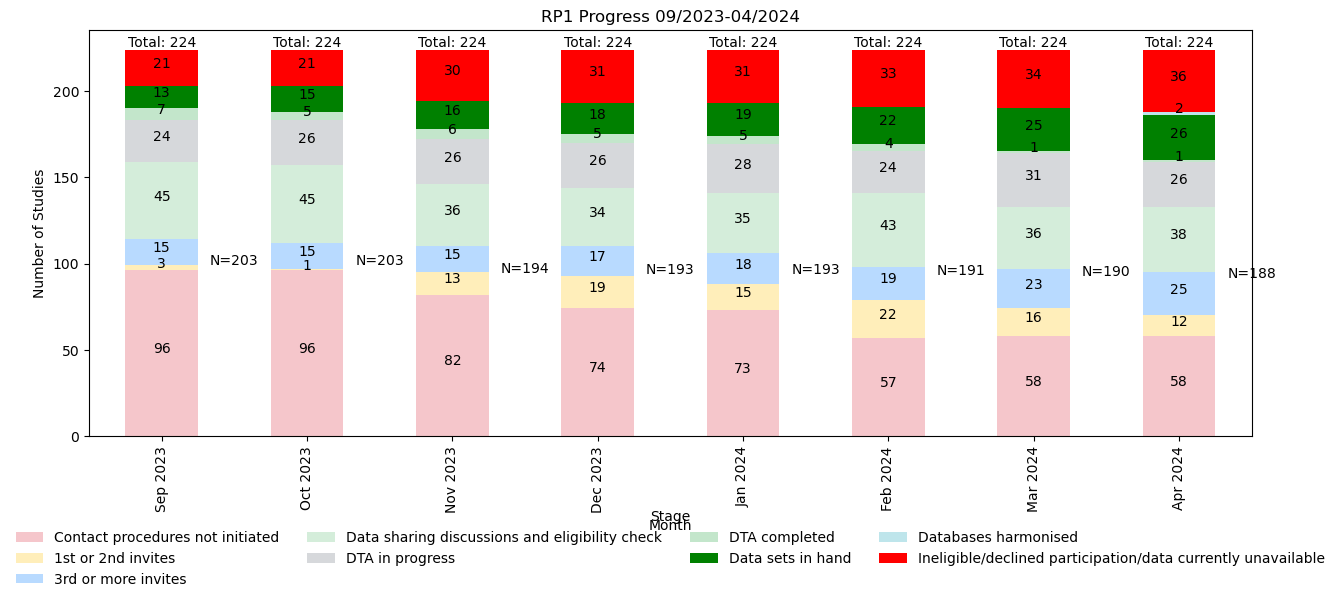

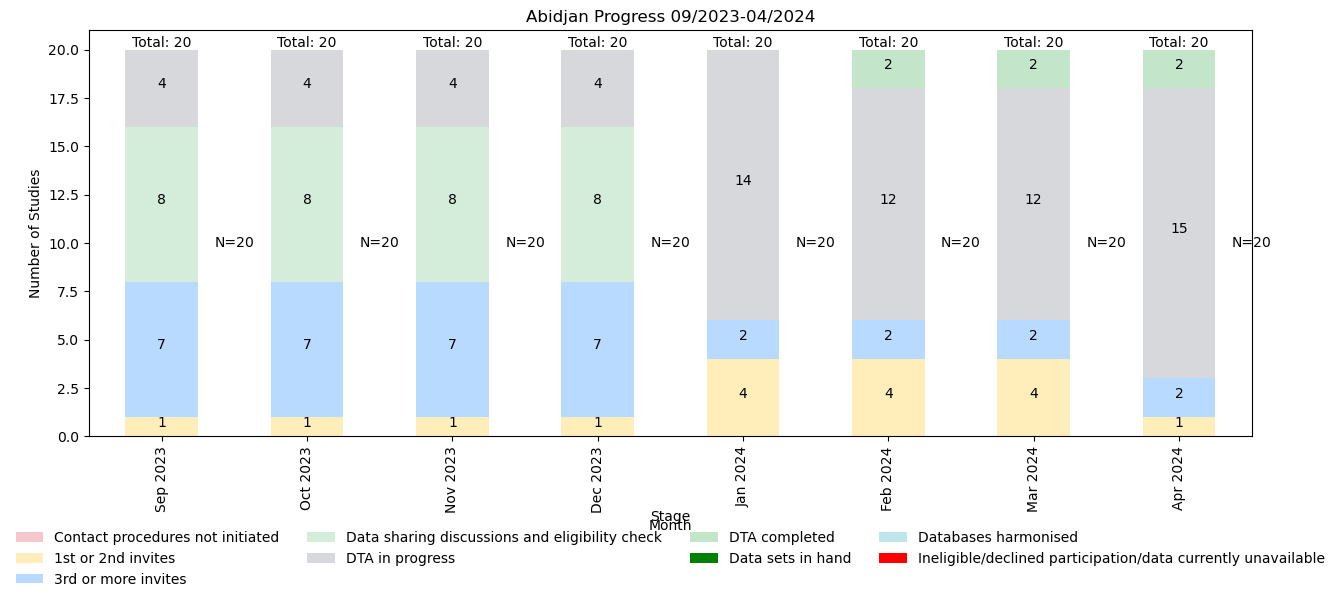

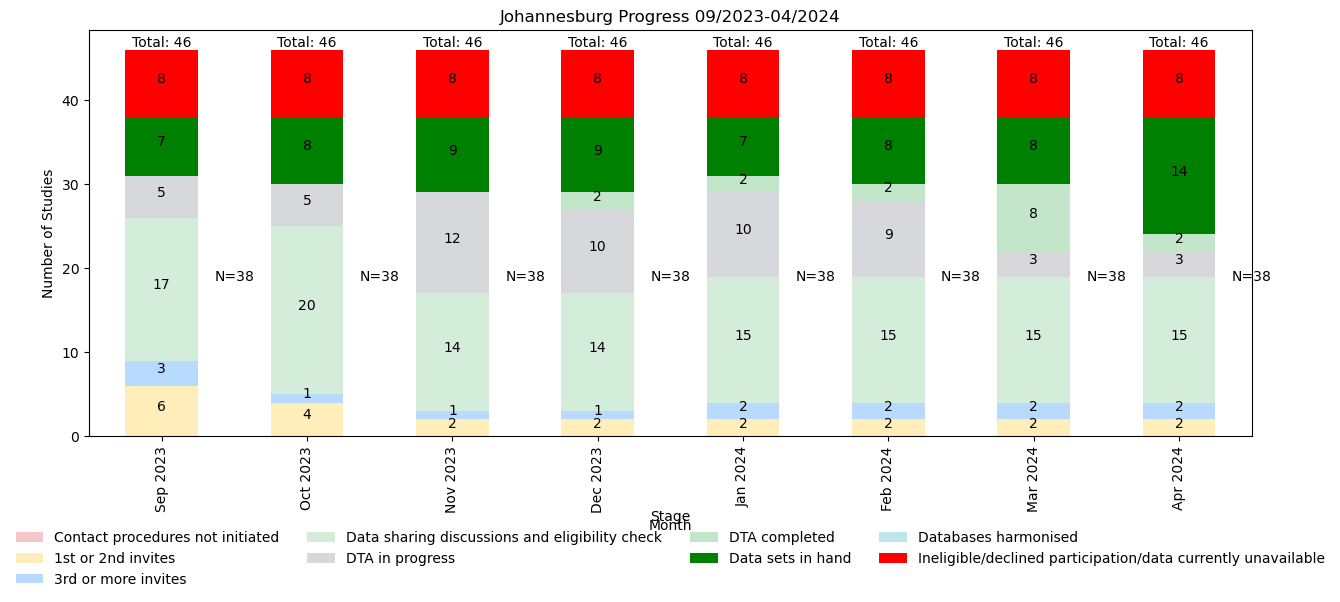

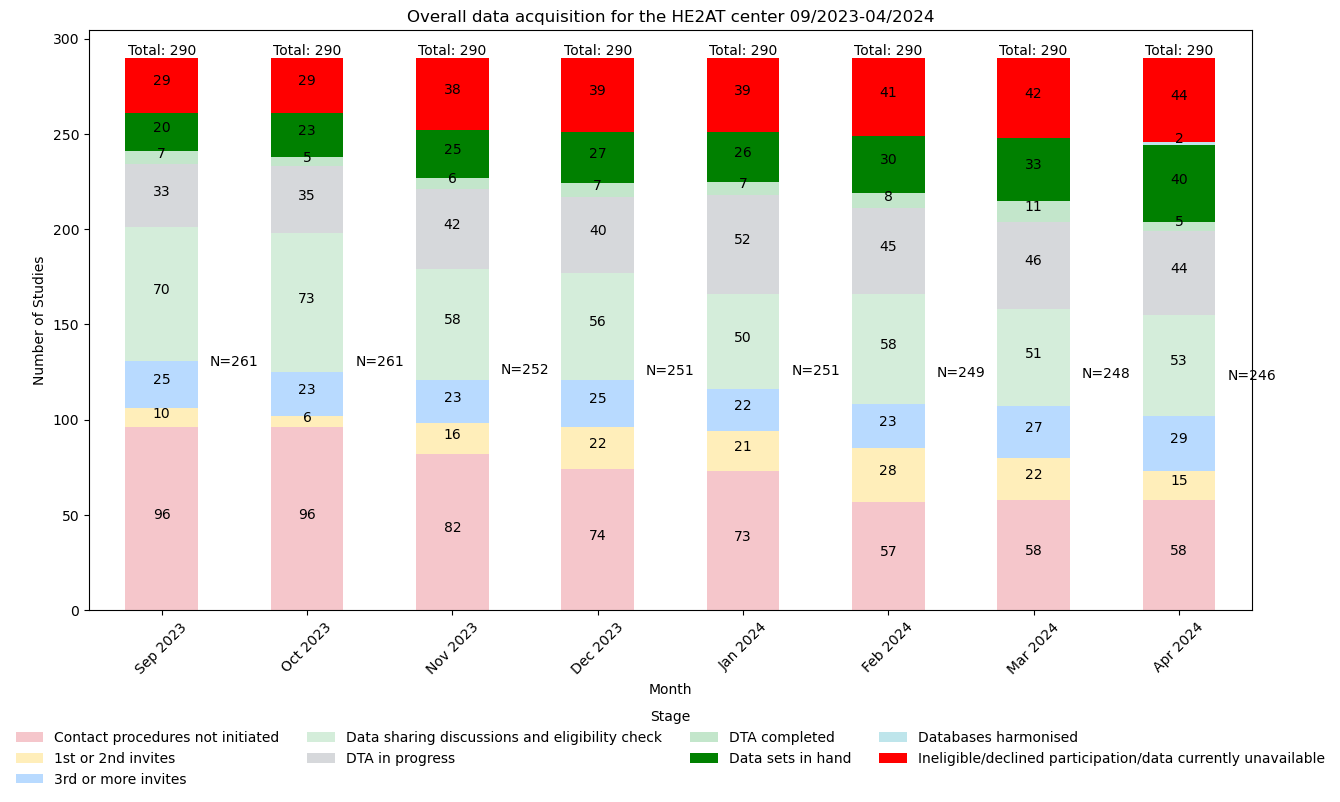

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the data from the Excel file into a dictionary of DataFrames
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1.index.tolist())
stages_abj = set(df_abj.index.tolist())
stages_jhb = set(df_jhb.index.tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb',
    'Ineligible/declined participation/data currently unavailable': 'red'
}
stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised',
    'Ineligible/declined participation/data currently unavailable'
]

# Plotting function for a single dataframe
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, label_shift=0.0):
    df = df.set_index('Stage').reindex(stage_order).reset_index()
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

plot_stacked_bar_chart(df_rp1, 'RP1 Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order).fillna(0)
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)



Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug        int64
Sep        int64
Oct        int64
Nov        int64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object
Index(['Stage', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023',
       'Jun 2023', 'Jul 2023', 'Aug 2023', 'Sep 2023', 'Oct 2023',

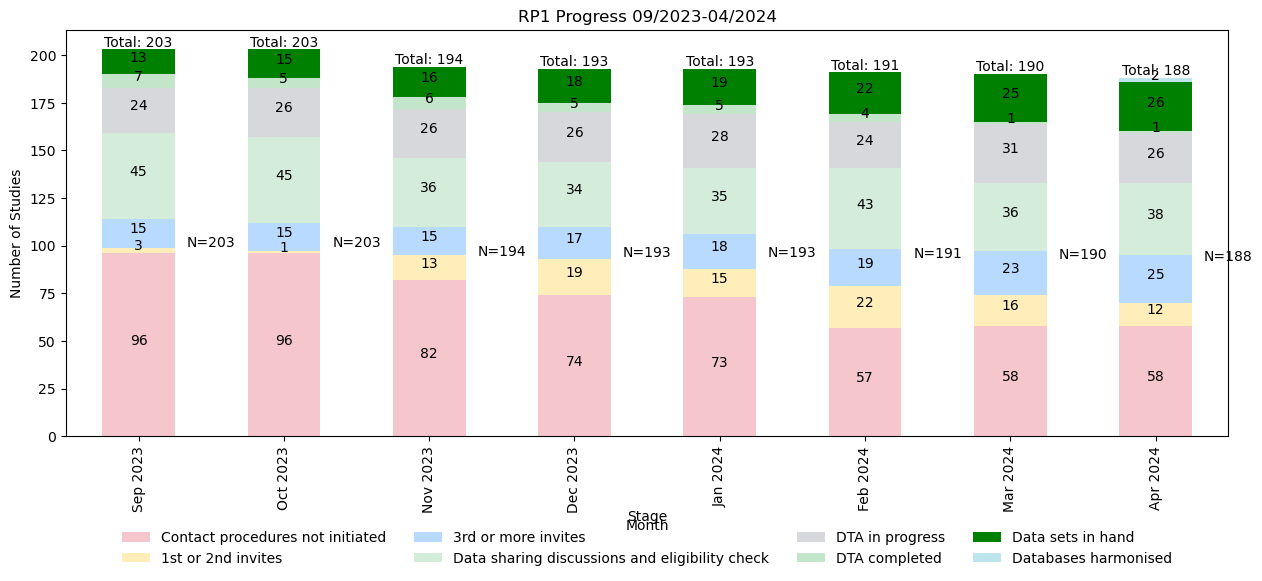

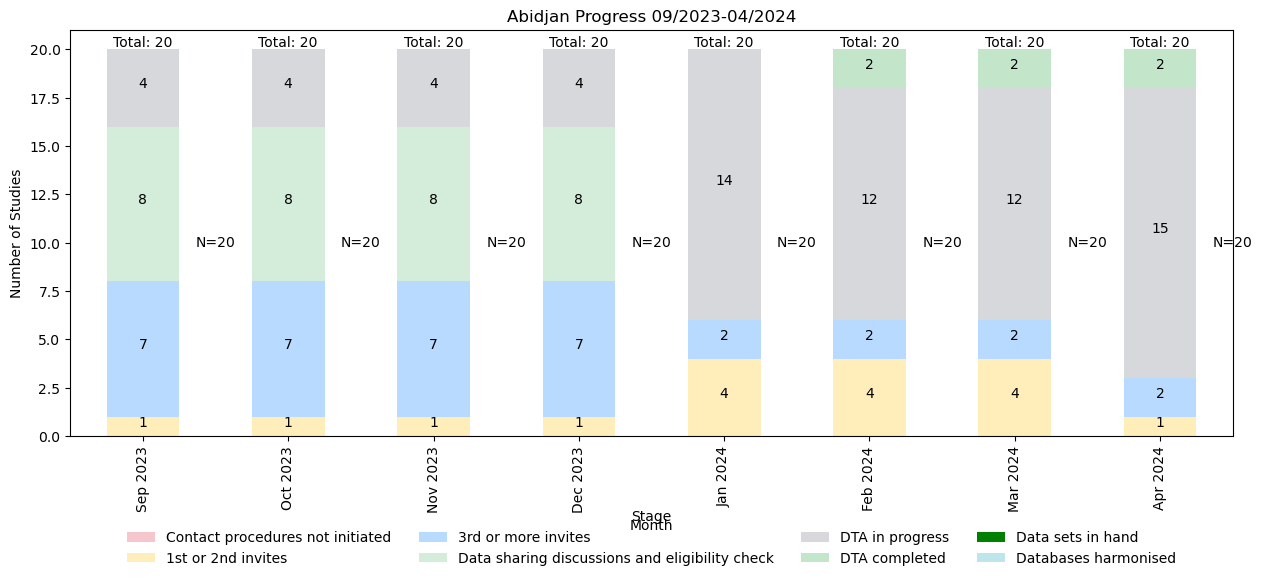

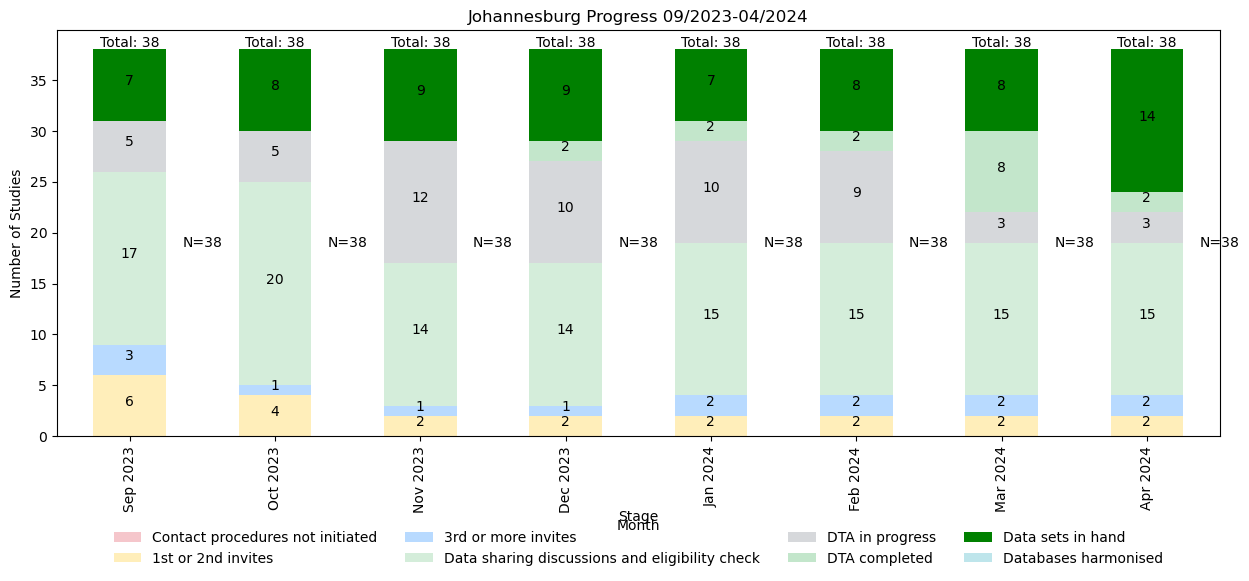

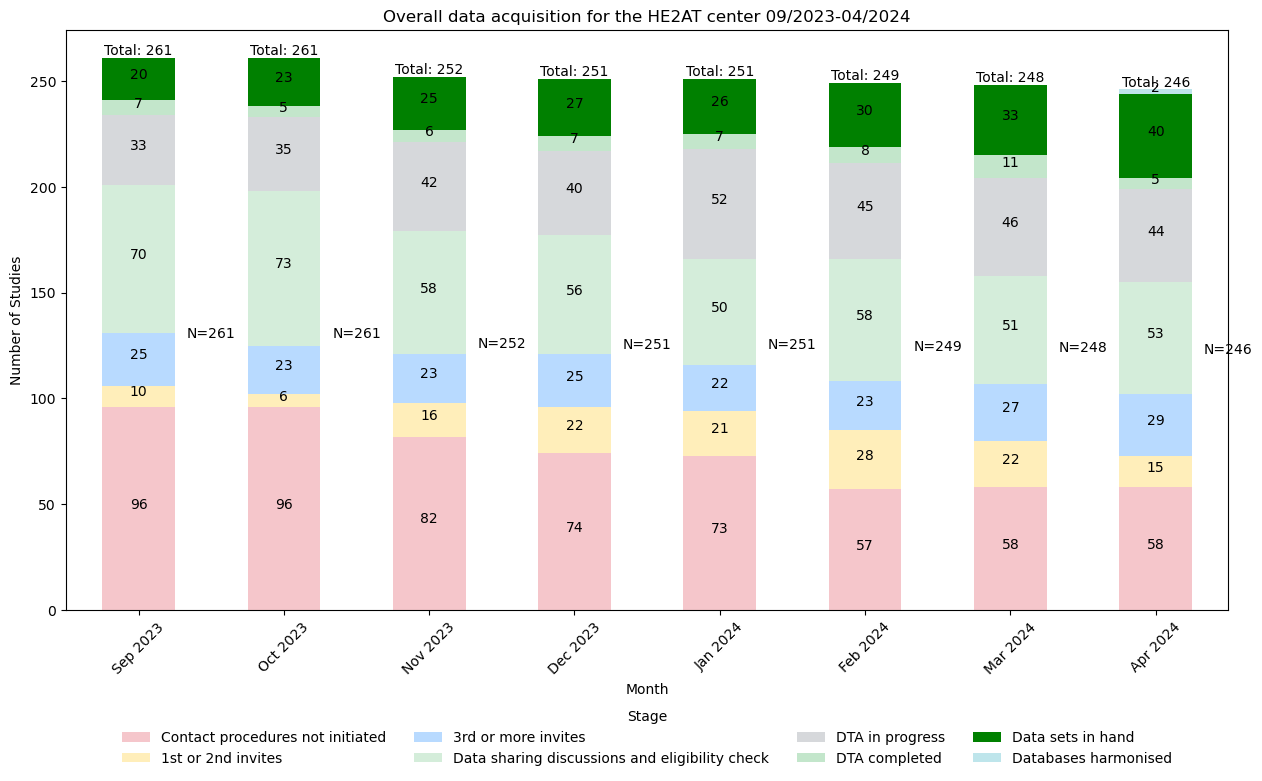

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the data from the Excel file into a dictionary of DataFrames
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1.index.tolist())
stages_abj = set(df_abj.index.tolist())
stages_jhb = set(df_jhb.index.tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb'
}
stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised'
]

# Plotting function for a single dataframe
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, label_shift=0.0):
    df = df.set_index('Stage').reindex(stage_order + ['Ineligible/declined participation/data currently unavailable']).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.drop('Stage', axis=1).transpose().sum()
        for i, month in enumerate(transposed_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, 0, f"n={int(excluded)} excluded", ha='center', va='bottom', color='red')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

plot_stacked_bar_chart(df_rp1, 'RP1 Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order + ['Ineligible/declined participation/data currently unavailable']).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.transpose().sum()
        for i, month in enumerate(filtered_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, 0, f"n={int(excluded)} excluded", ha='center', va='bottom', color='red')

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)




Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug        int64
Sep        int64
Oct        int64
Nov        int64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object
Index(['Stage', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023',
       'Jun 2023', 'Jul 2023', 'Aug 2023', 'Sep 2023', 'Oct 2023',

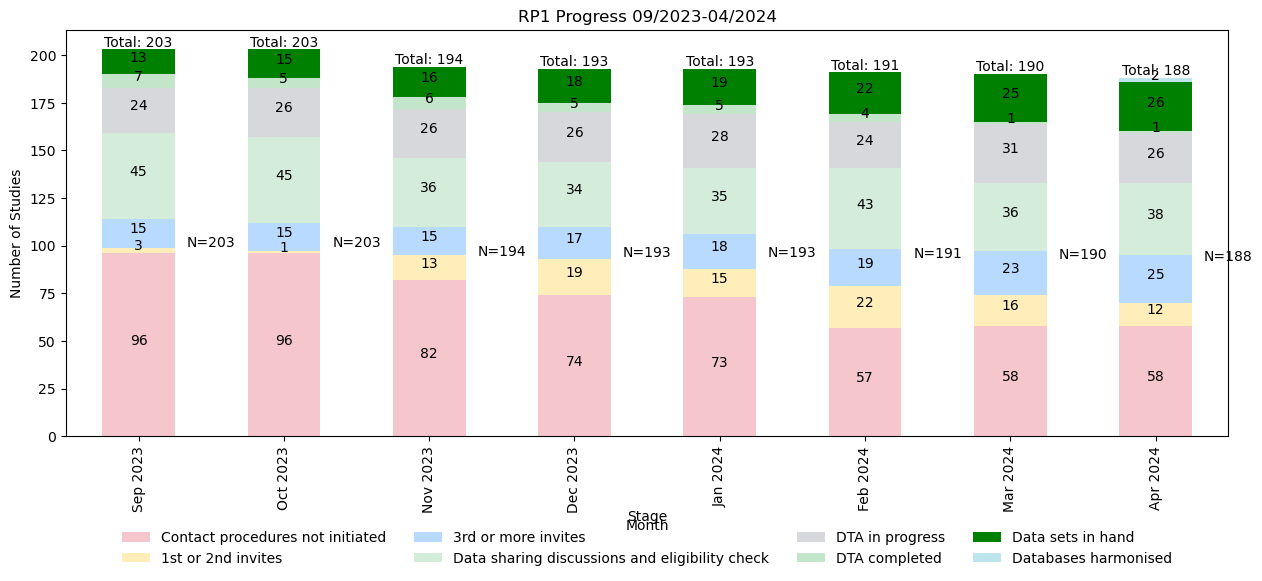

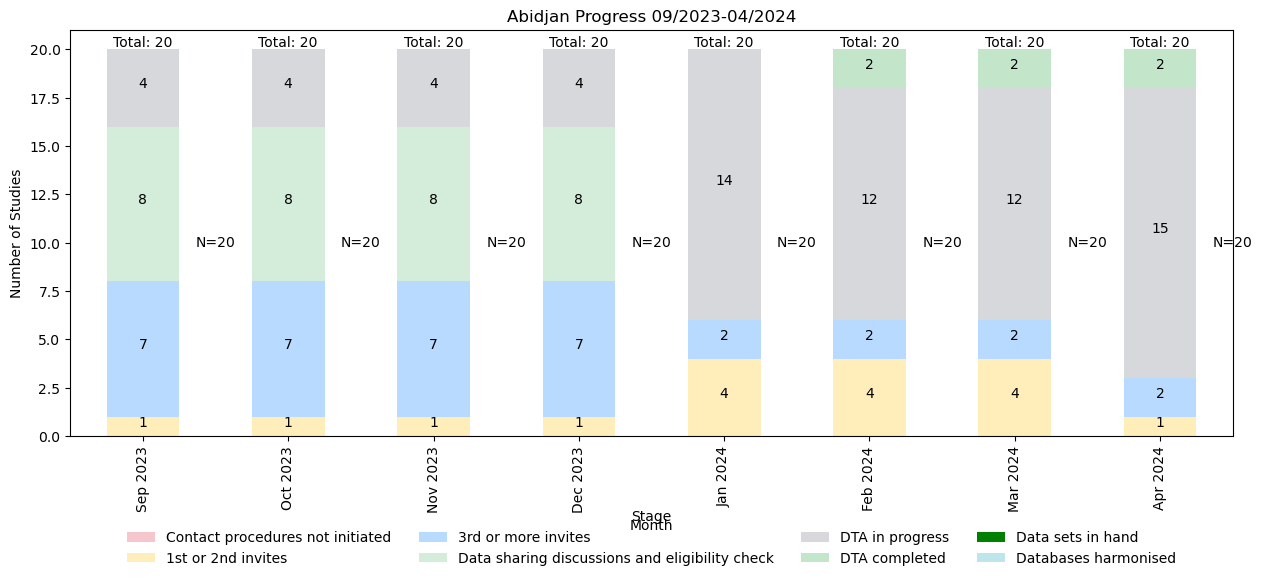

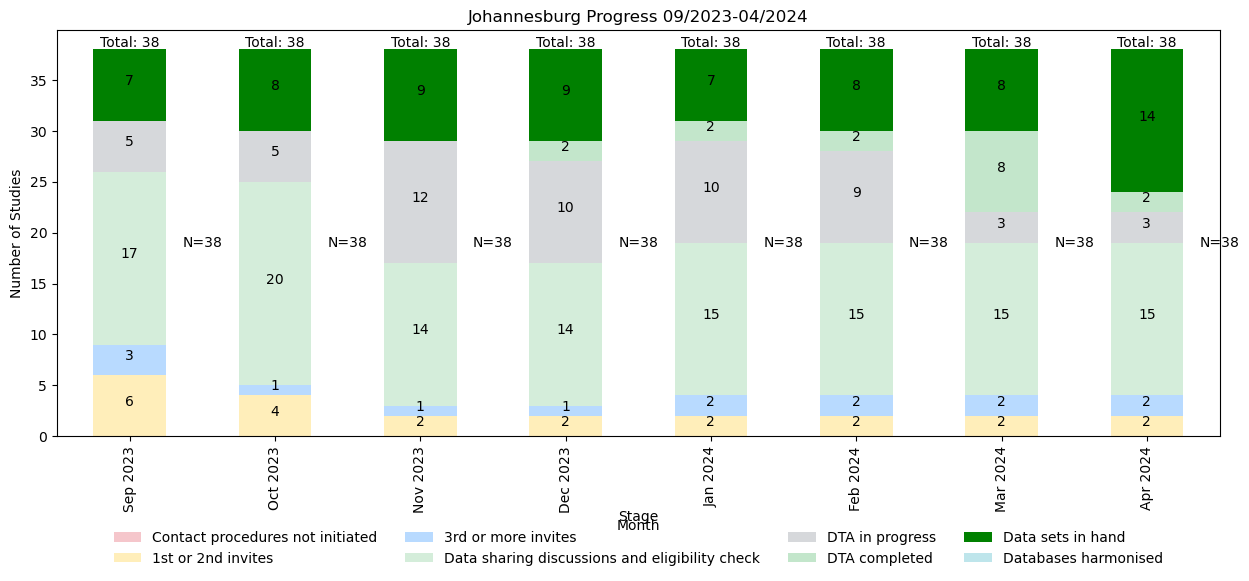

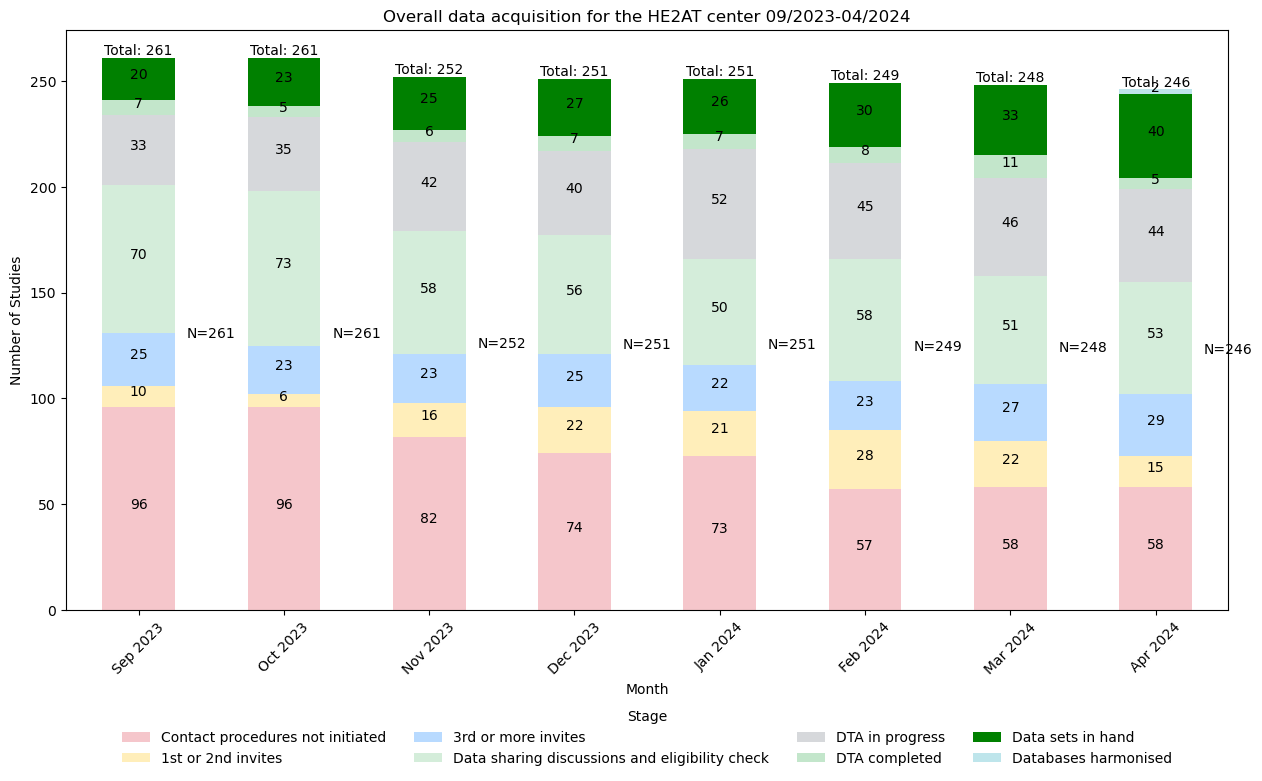

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1.index.tolist())
stages_abj = set(df_abj.index.tolist())
stages_jhb = set(df_jhb.index.tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb',
    'Ineligible/declined participation/data currently unavailable': '#f5b7b1'
}
stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised',
    'Ineligible/declined participation/data currently unavailable'
]

# Plotting function for a single dataframe
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, label_shift=0.0):
    df = df.set_index('Stage').reindex(stage_order).fillna(0).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.drop('Stage', axis=1).transpose().sum()
        for i, month in enumerate(transposed_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, 0, f"n={int(excluded)} excluded", ha='center', va='bottom', color='red')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot for each DataFrame
plot_stacked_bar_chart(df_rp1, 'RP1 Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.transpose().sum()
        for i, month in enumerate(filtered_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, 0, f"n={int(excluded)} excluded", ha='center', va='bottom', color='red')

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)


Stages unique to df_rp1: {8}
Stages unique to df_abj: set()
Stages unique to df_jhb: set()
Common stages: {0, 1, 2, 3, 4, 5, 6, 7}
There are differences in the stage names across the dataframes.


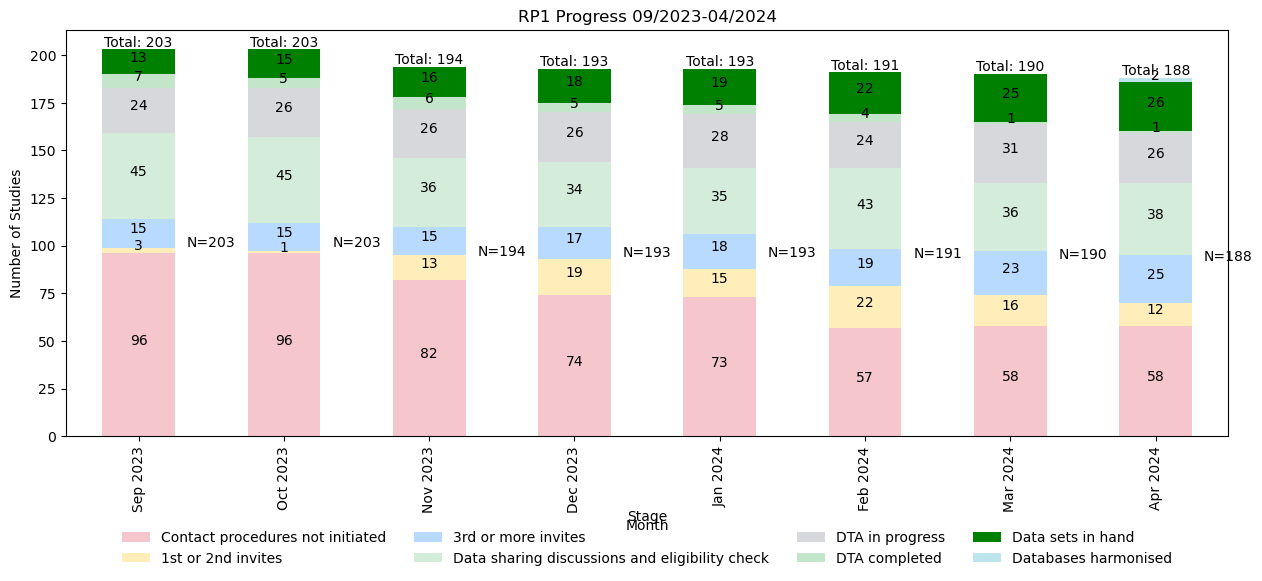

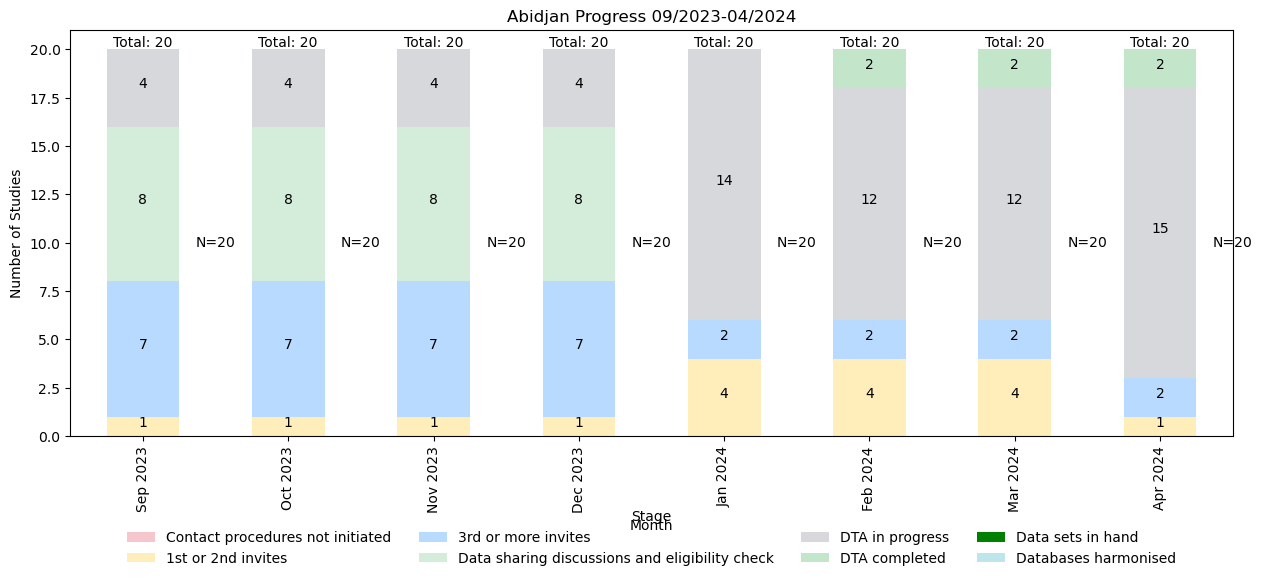

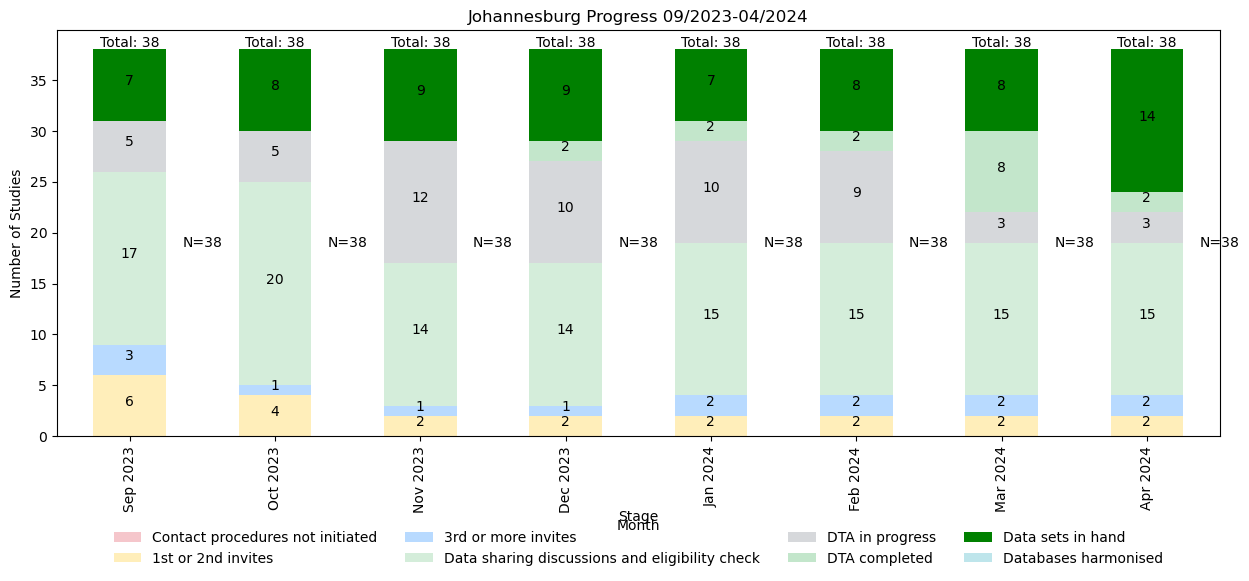

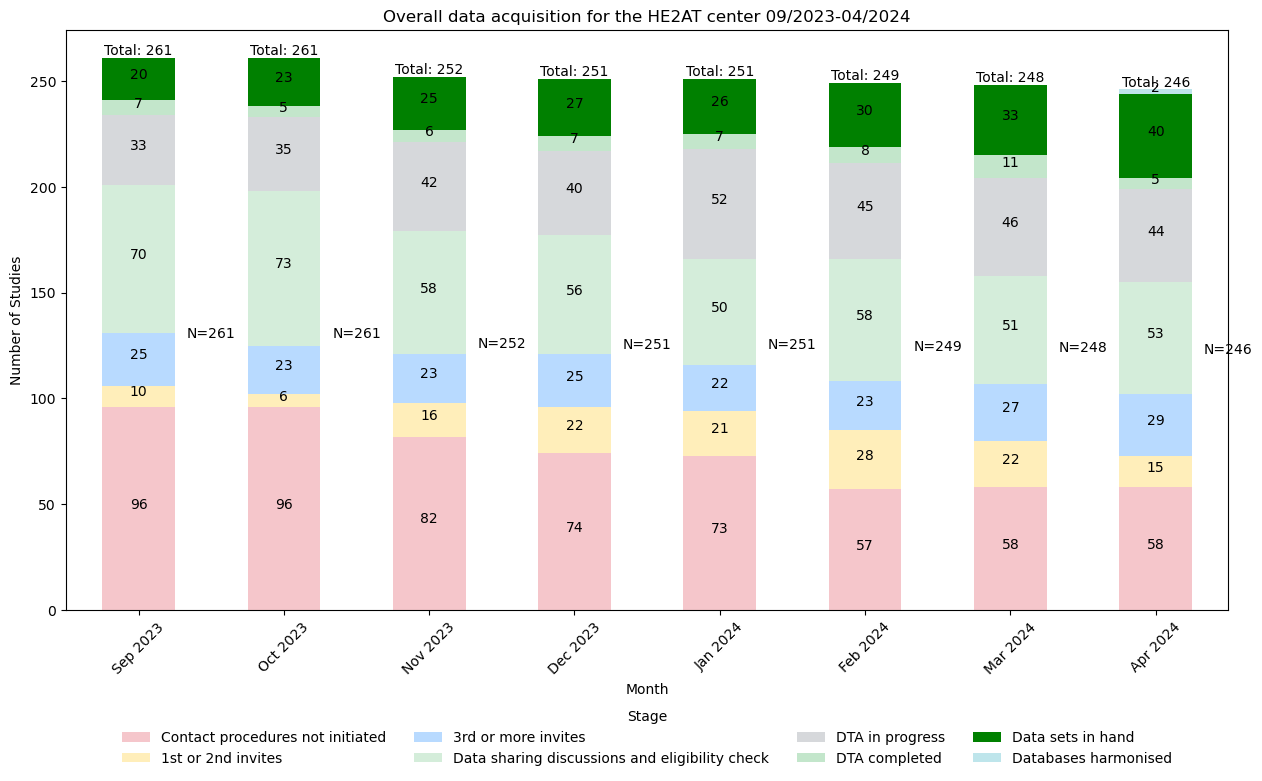

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1.index.tolist())
stages_abj = set(df_abj.index.tolist())
stages_jhb = set(df_jhb.index.tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb',
    'Ineligible/declined participation/data currently unavailable': '#f5b7b1'
}
stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised',
    'Ineligible/declined participation/data currently unavailable'
]

# Plotting function for a single dataframe
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, label_shift=0.0):
    df = df.set_index('Stage').reindex(stage_order).fillna(0).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.drop('Stage', axis=1).transpose().sum()
        for i, month in enumerate(transposed_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, -excluded, f"Excluded: {int(excluded)}", ha='center', va='top', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot for each DataFrame
plot_stacked_bar_chart(df_rp1, 'RP1 Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.transpose().sum()
        for i, month in enumerate(filtered_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, -excluded, f"Excluded: {int(excluded)}", ha='center', va='top', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)


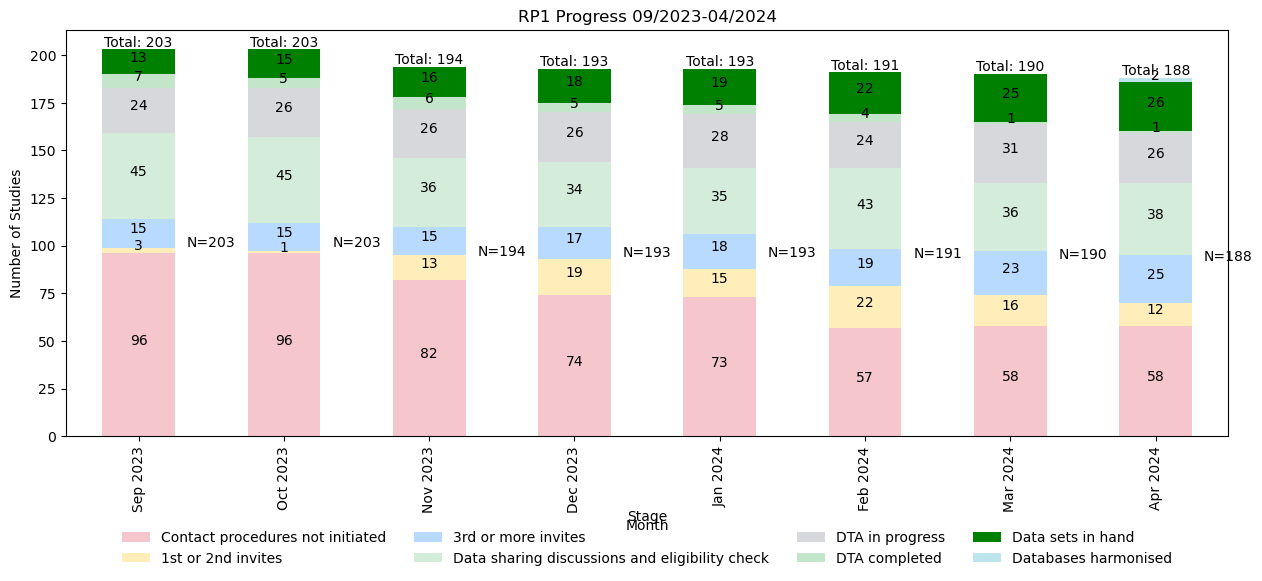

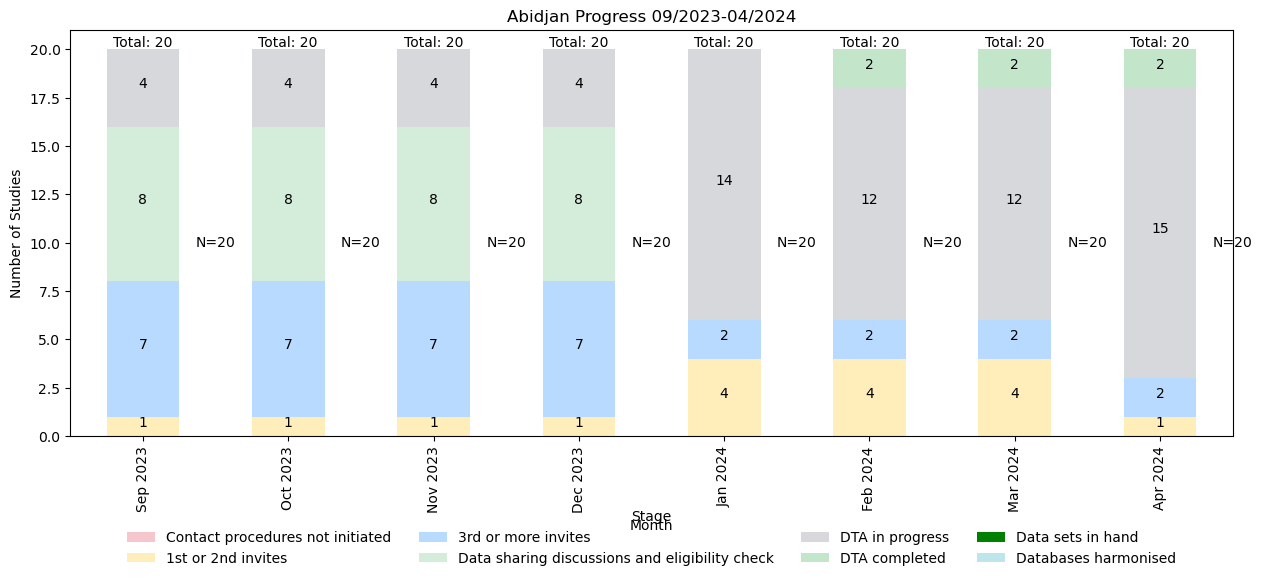

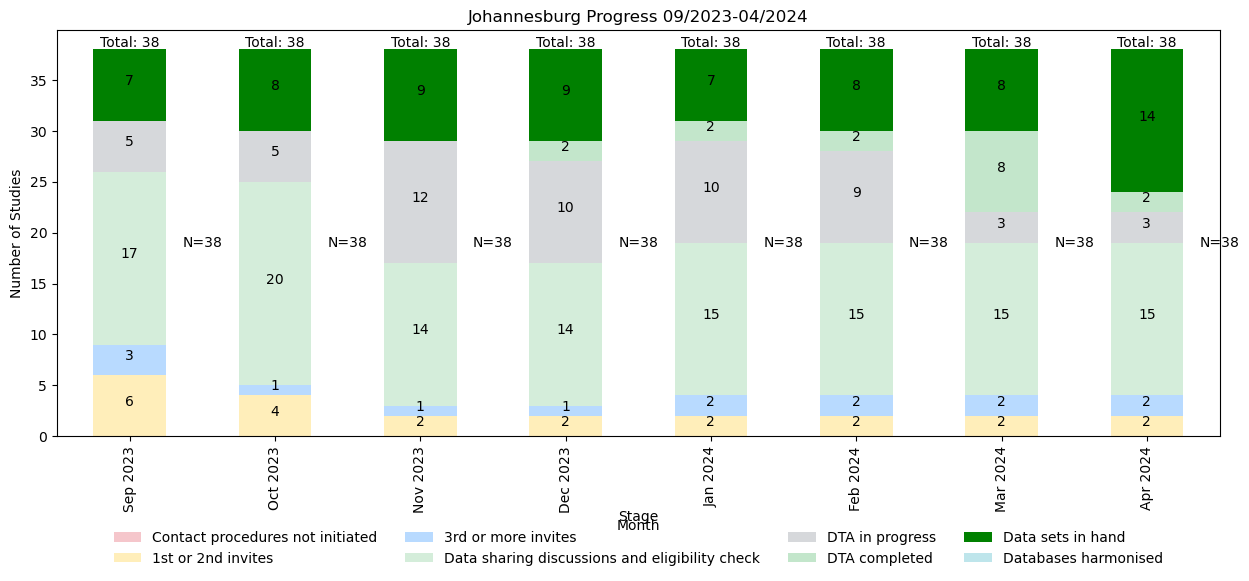

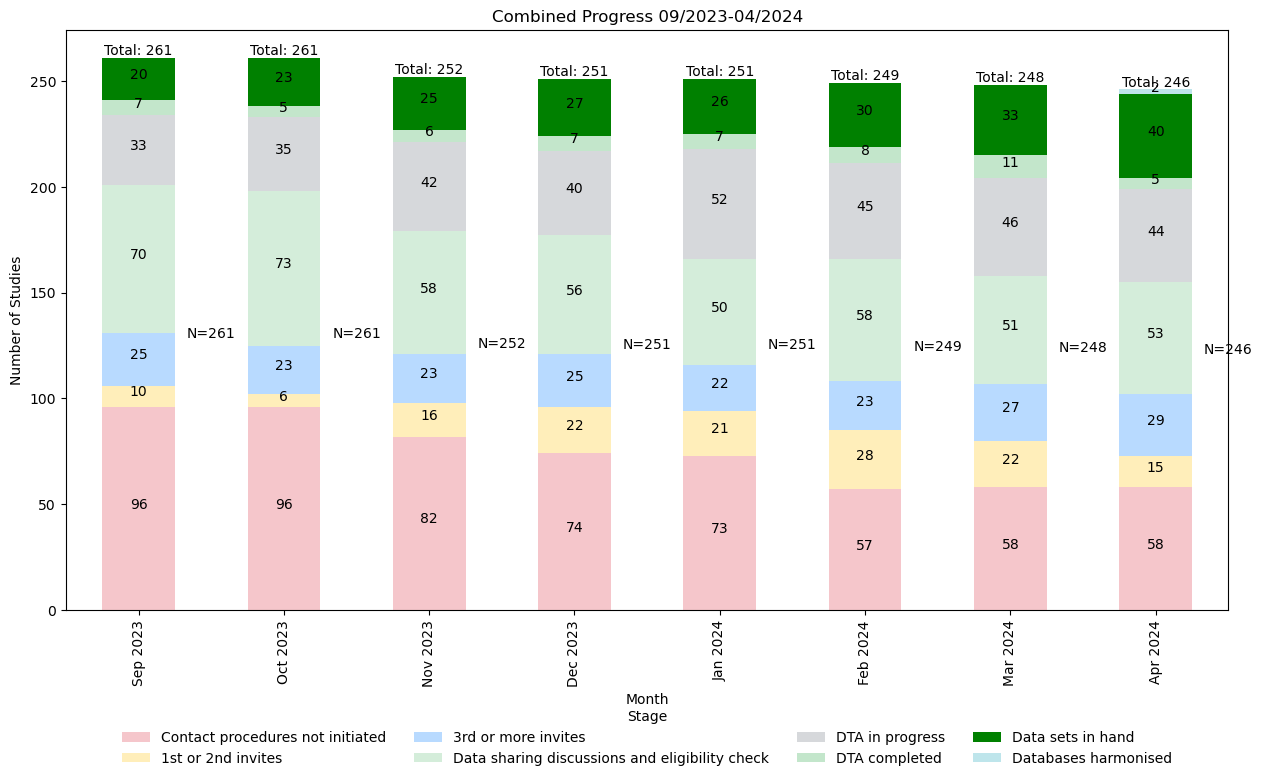

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Ensure consistent stages across all dataframes
all_stages = set(df_rp1['Stage']).union(set(df_abj['Stage'])).union(set(df_jhb['Stage']))

def add_missing_stages(df, all_stages):
    missing_stages = all_stages.difference(df['Stage'])
    for stage in missing_stages:
        new_row = pd.DataFrame([[stage] + [0]*(df.shape[1]-1)], columns=df.columns)
        df = pd.concat([df, new_row], ignore_index=True)
    return df

df_rp1 = add_missing_stages(df_rp1, all_stages)
df_abj = add_missing_stages(df_abj, all_stages)
df_jhb = add_missing_stages(df_jhb, all_stages)

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb',
    'Ineligible/declined participation/data currently unavailable': '#f5b7b1'
}

stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised',
    'Ineligible/declined participation/data currently unavailable'
]

# Plotting function for a single dataframe
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, label_shift=0.0):
    df = df.set_index('Stage').reindex(stage_order).fillna(0).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.drop('Stage', axis=1).transpose().sum()
        for i, month in enumerate(transposed_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, -excluded, f"Excluded: {int(excluded)}", ha='center', va='top', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot for each DataFrame
plot_stacked_bar_chart(df_rp1, 'RP1 Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.sum(axis=1)
        for i, month in enumerate(filtered_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, -excluded, f"Excluded: {int(excluded)}", ha='center', va='top', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in filtered_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Combined plot for all dataframes
combine_and_plot_stacked_bars([df_rp1, df_abj, df_jhb], 'Combined Progress 09/2023-04/2024', start_month=9, start_year=2023, stage_order=stage_order, color_map=color_map)


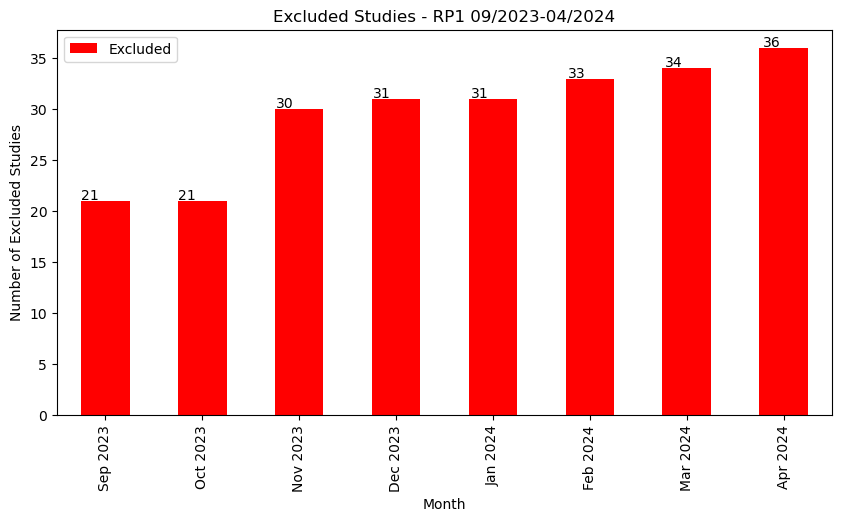

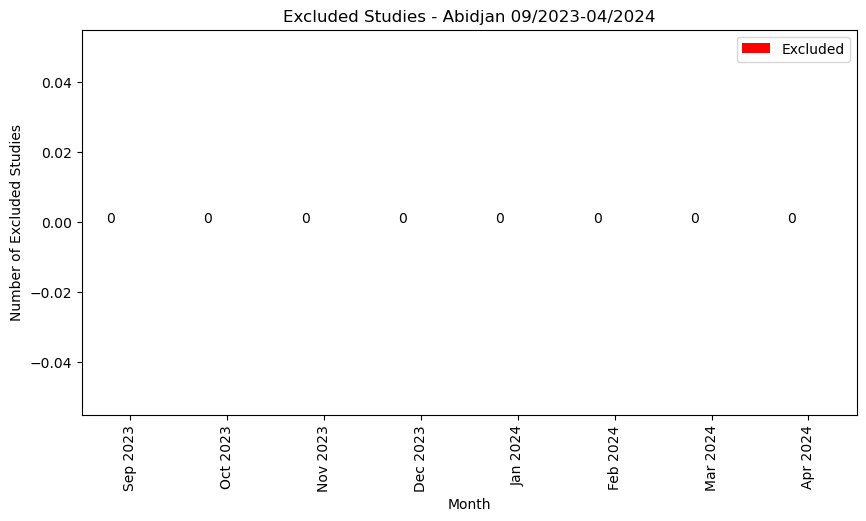

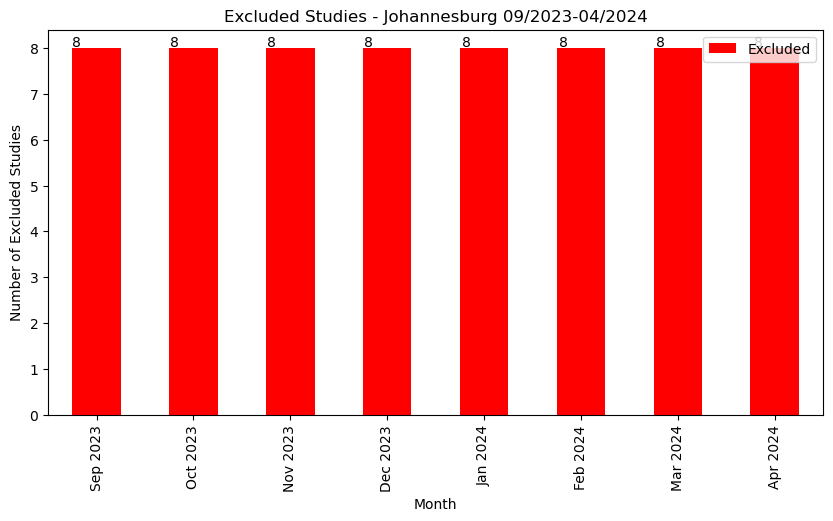

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Define the function to plot excluded studies
def plot_excluded_studies(df, title, last_n_months=8):
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    if excluded_df.empty:
        print(f"No excluded studies data for {title}")
        return
    
    excluded_df = excluded_df.drop('Stage', axis=1).transpose()
    excluded_df.columns = ['Excluded']
    excluded_df = excluded_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(10, 5))
    excluded_df.plot(kind='bar', ax=ax, color='red')

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.0f}", (p.get_x() * 1.005, p.get_height() * 1.005))

    ax.set_xticklabels([x.strftime('%b %Y') for x in excluded_df.index])
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Excluded Studies')
    plt.show()

# Plot excluded studies for each dataframe
plot_excluded_studies(df_rp1, 'Excluded Studies - RP1 09/2023-04/2024')
plot_excluded_studies(df_abj, 'Excluded Studies - Abidjan 09/2023-04/2024')
plot_excluded_studies(df_jhb, 'Excluded Studies - Johannesburg 09/2023-04/2024')


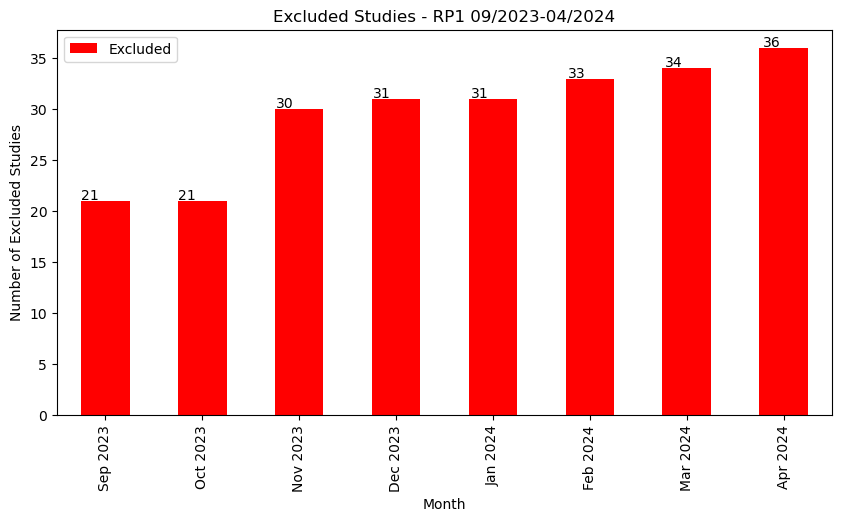

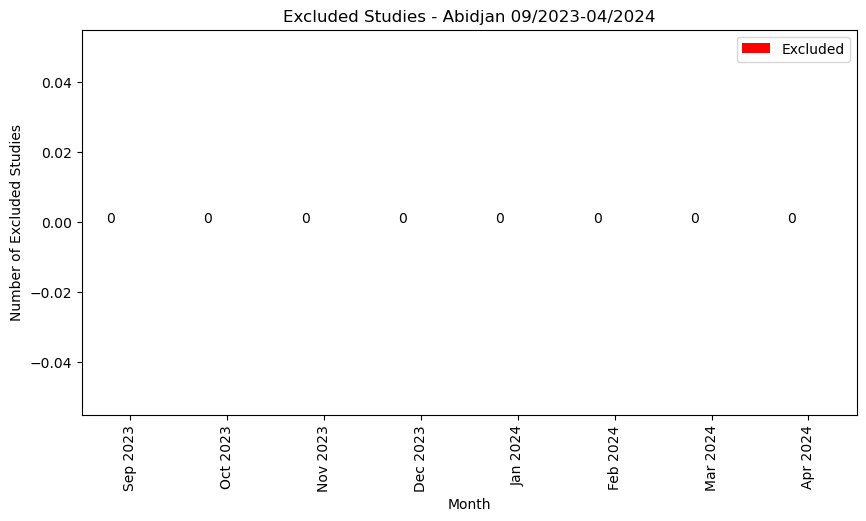

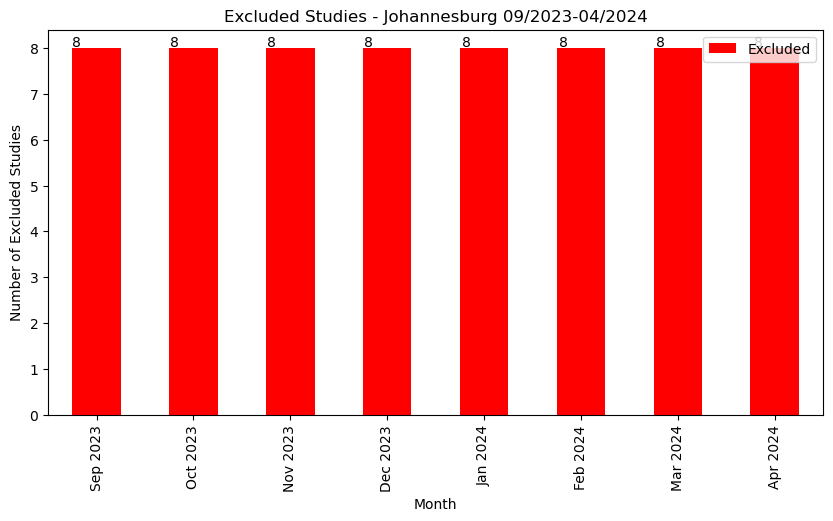

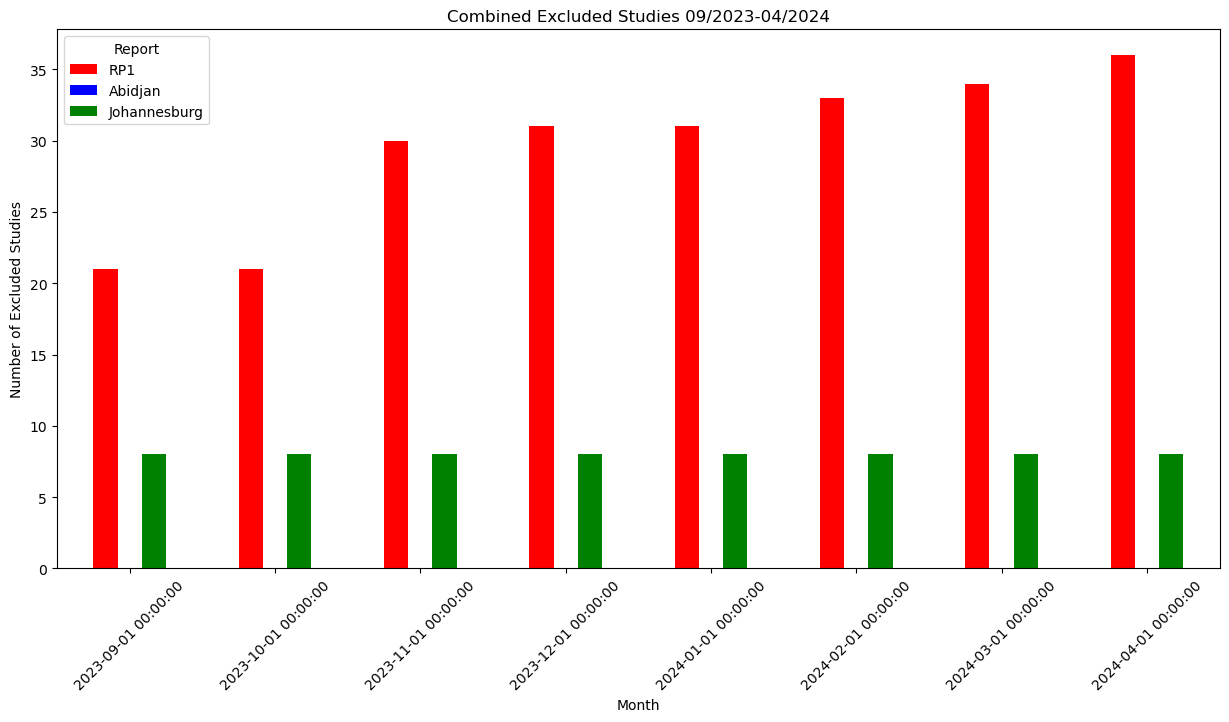

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Define the function to plot excluded studies
def plot_excluded_studies(df, title, last_n_months=8):
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    if excluded_df.empty:
        print(f"No excluded studies data for {title}")
        return
    
    excluded_df = excluded_df.drop('Stage', axis=1).transpose()
    excluded_df.columns = ['Excluded']
    excluded_df = excluded_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(10, 5))
    excluded_df.plot(kind='bar', ax=ax, color='red')

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.0f}", (p.get_x() * 1.005, p.get_height() * 1.005))

    ax.set_xticklabels([x.strftime('%b %Y') for x in excluded_df.index])
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Excluded Studies')
    plt.show()

# Plot excluded studies for each dataframe
plot_excluded_studies(df_rp1, 'Excluded Studies - RP1 09/2023-04/2024')
plot_excluded_studies(df_abj, 'Excluded Studies - Abidjan 09/2023-04/2024')
plot_excluded_studies(df_jhb, 'Excluded Studies - Johannesburg 09/2023-04/2024')

# Combining and plotting function for multiple dataframes
def combine_and_plot_excluded_studies(dfs, titles, last_n_months=8):
    combined_df = pd.DataFrame()
    for df, title in zip(dfs, titles):
        excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
        if excluded_df.empty:
            print(f"No excluded studies data for {title}")
            continue
        excluded_df = excluded_df.drop('Stage', axis=1).transpose()
        excluded_df.columns = [title]
        combined_df = pd.concat([combined_df, excluded_df], axis=1)
    
    combined_df = combined_df.iloc[-last_n_months:]
    
    if combined_df.empty:
        print("No excluded studies data across all reports.")
        return

    combined_df.plot(kind='bar', figsize=(15, 7), color=['red', 'blue', 'green'])

    plt.title('Combined Excluded Studies 09/2023-04/2024')
    plt.xlabel('Month')
    plt.ylabel('Number of Excluded Studies')
    plt.xticks(rotation=45)
    plt.legend(title='Report')
    plt.show()

# Plot combined excluded studies
combine_and_plot_excluded_studies([df_rp1, df_abj, df_jhb], ['RP1', 'Abidjan', 'Johannesburg'], last_n_months=8)


In [2]:
# Print unique stage names from each dataframe
print("Unique stage names in df_rp1:", df_rp1['Stage'].unique())
print("Unique stage names in df_abj:", df_abj['Stage'].unique())
print("Unique stage names in df_jhb:", df_jhb['Stage'].unique())


Unique stage names in df_rp1: ['Contact procedures not initiated' '1st or 2nd invites'
 '3rd or more invites' 'Data sharing discussions and eligibility check'
 'DTA in progress' 'DTA completed' 'Data sets in hand'
 'Databases harmonised'
 'Ineligible/declined participation/data currently unavailable']
Unique stage names in df_abj: ['Contact procedures not initiated'
 'Ineligible/declined participation/data currently unavailable'
 '1st or 2nd invites' '3rd or more invites'
 'Data sharing discussions and eligibility check' 'DTA in progress'
 'DTA completed' 'Data sets in hand']
Unique stage names in df_jhb: ['Contact procedures not initiated'
 'Ineligible/declined participation/data currently unavailable'
 '1st or 2nd invites' '3rd or more invites'
 'Data sharing discussions and eligibility check' 'DTA in progress'
 'DTA completed' 'Data sets in hand']


Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug        int64
Sep        int64
Oct        int64
Nov        int64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object
Index(['Stage', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023',
       'Jun 2023', 'Jul 2023', 'Aug 2023', 'Sep 2023', 'Oct 2023',

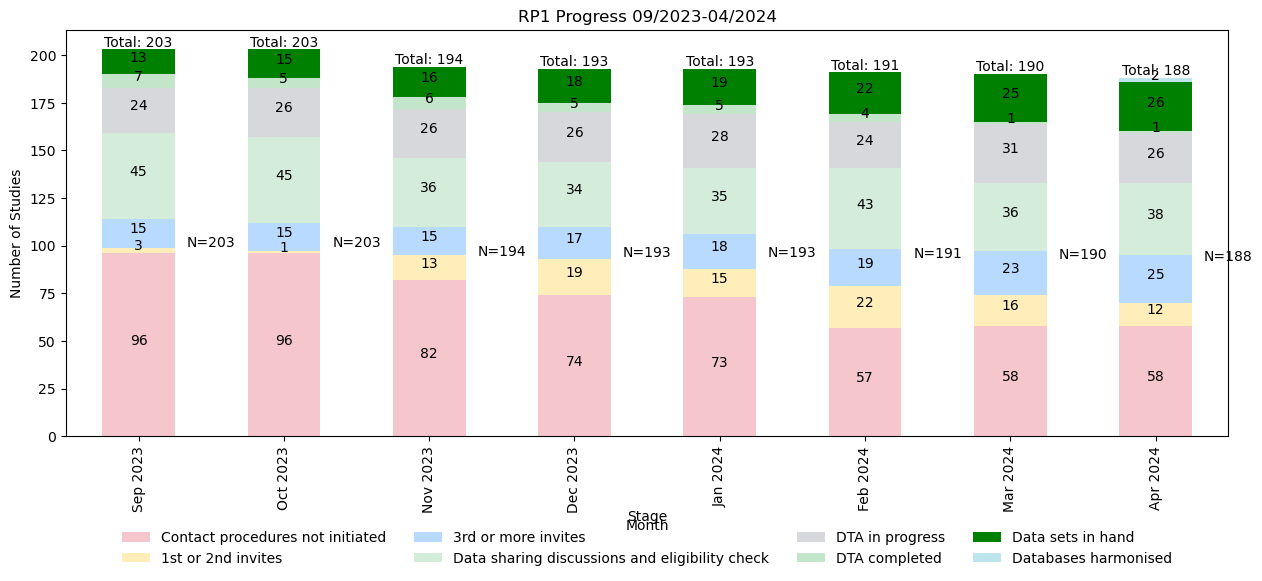

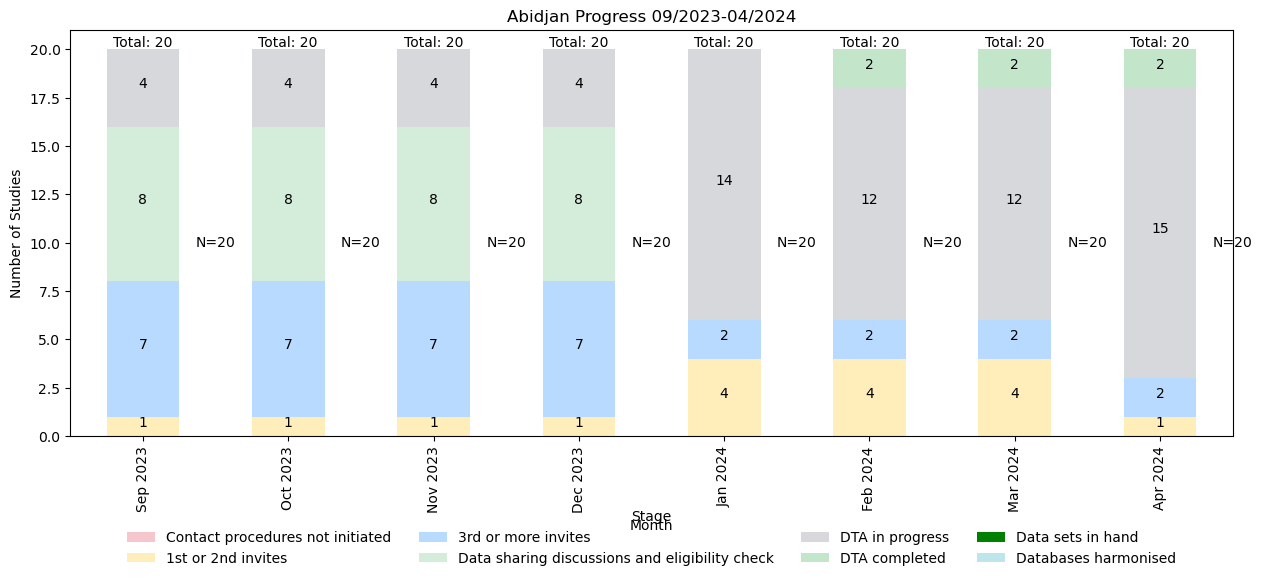

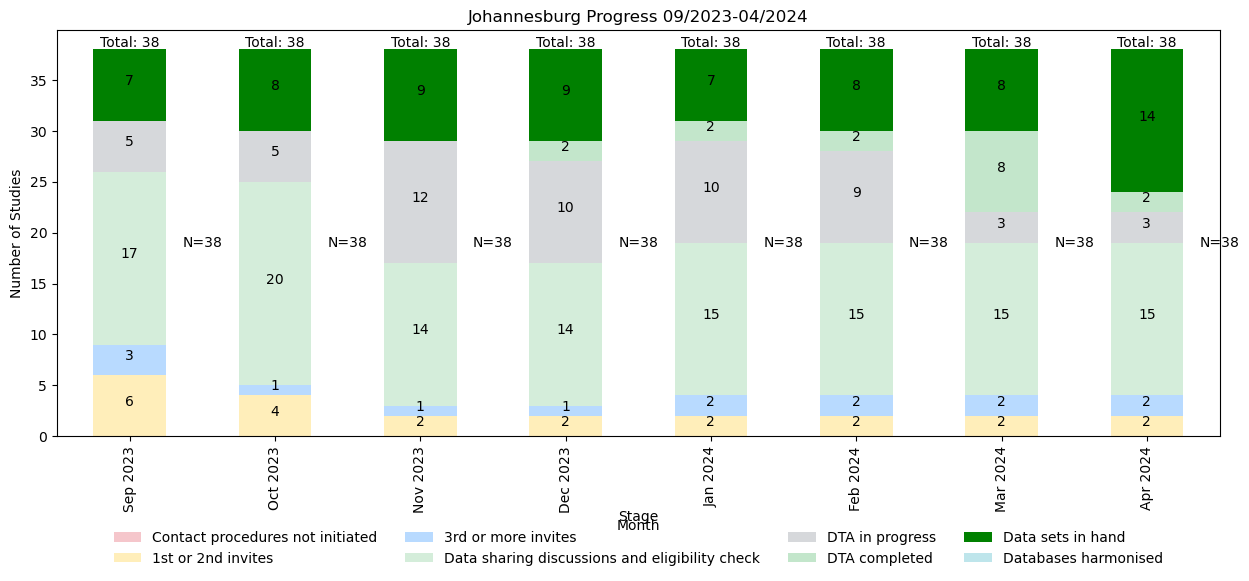

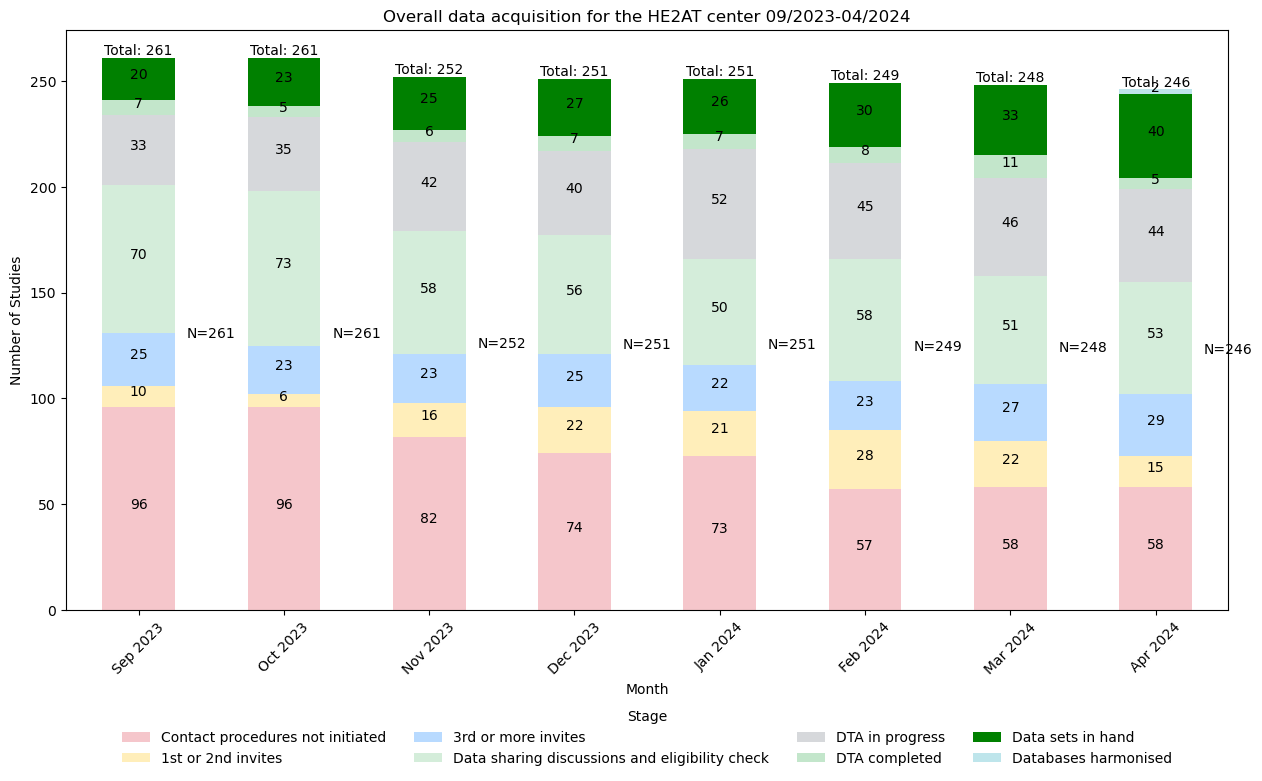

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1.index.tolist())
stages_abj = set(df_abj.index.tolist())
stages_jhb = set(df_jhb.index.tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb',
    'Ineligible/declined participation/data currently unavailable': '#f5b7b1'
}
stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised',
    'Ineligible/declined participation/data currently unavailable'
]

# Plotting function for a single dataframe
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, label_shift=0.0):
    df = df.set_index('Stage').reindex(stage_order).fillna(0).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.drop('Stage', axis=1).transpose().sum()
        for i, month in enumerate(transposed_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, -excluded, f"Excluded: {int(excluded)}", ha='center', va='top', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot for each DataFrame
plot_stacked_bar_chart(df_rp1, 'RP1 Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.transpose().sum()
        for i, month in enumerate(filtered_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, -excluded, f"Excluded: {int(excluded)}", ha='center', va='top', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)


Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug        int64
Sep        int64
Oct        int64
Nov        int64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
dtype: object
Index(['Stage', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023',
       'Jun 2023', 'Jul 2023', 'Aug 2023', 'Sep 2023', 'Oct 2023',

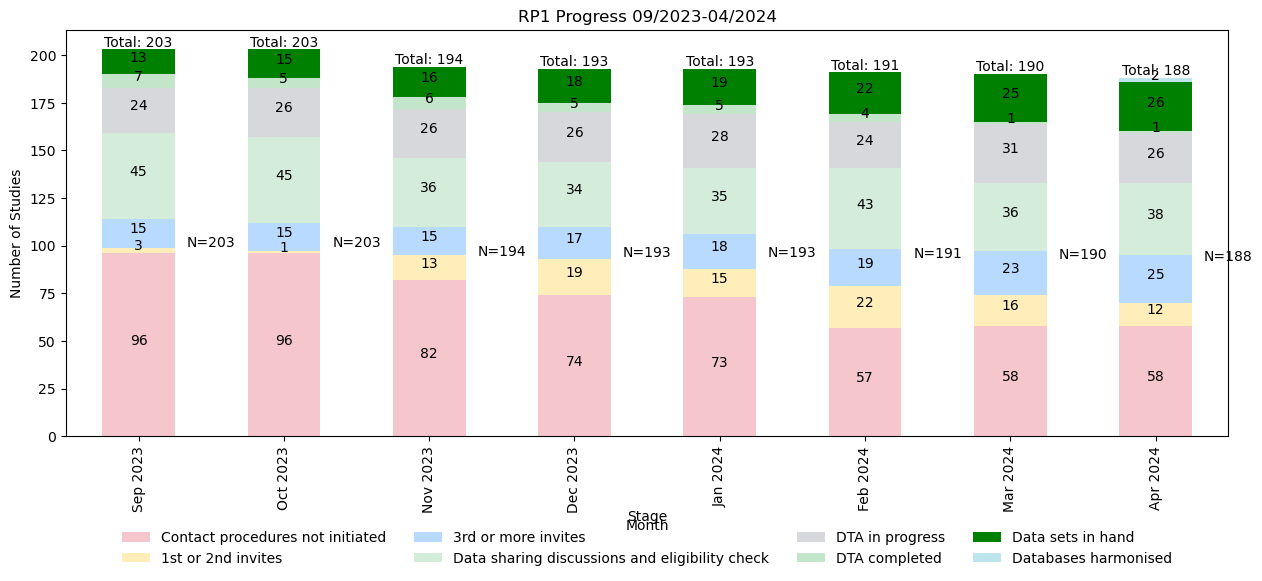

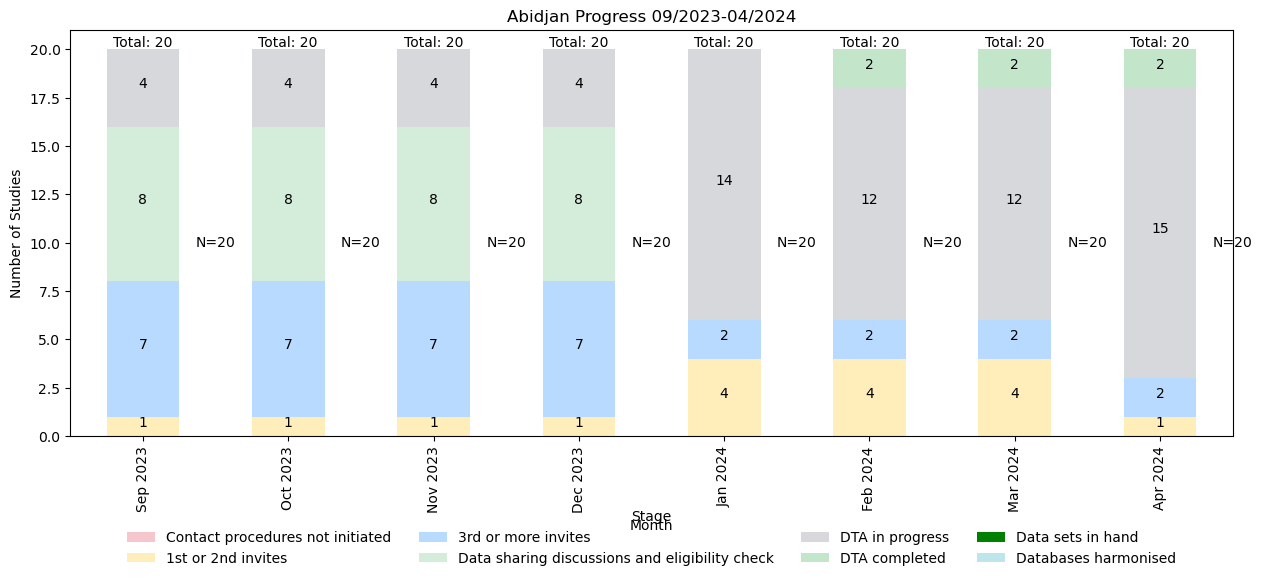

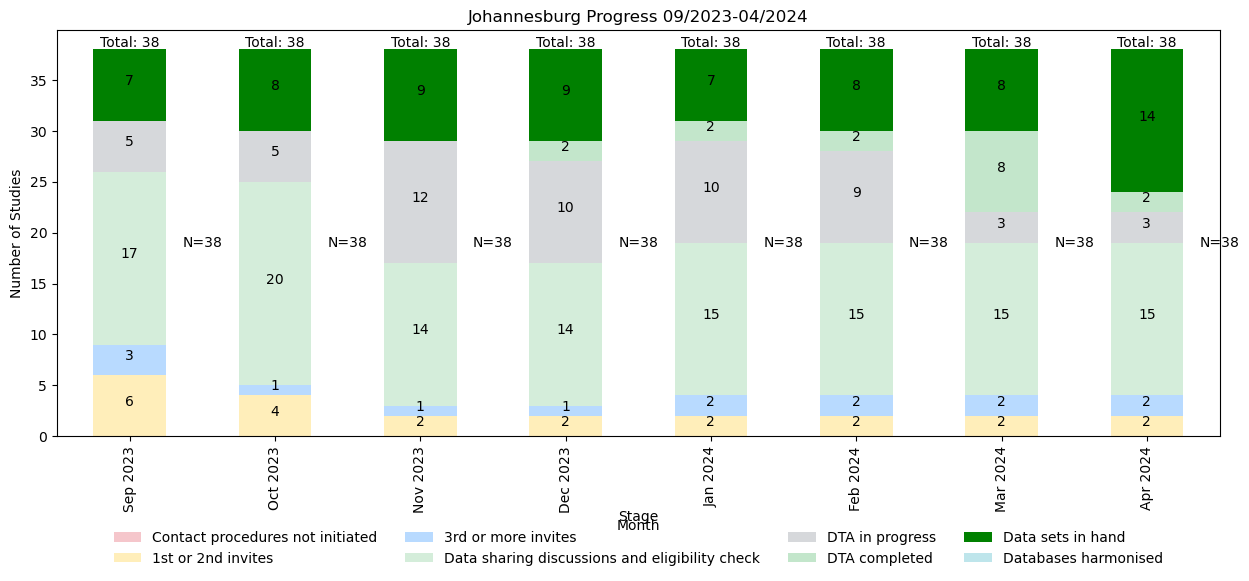

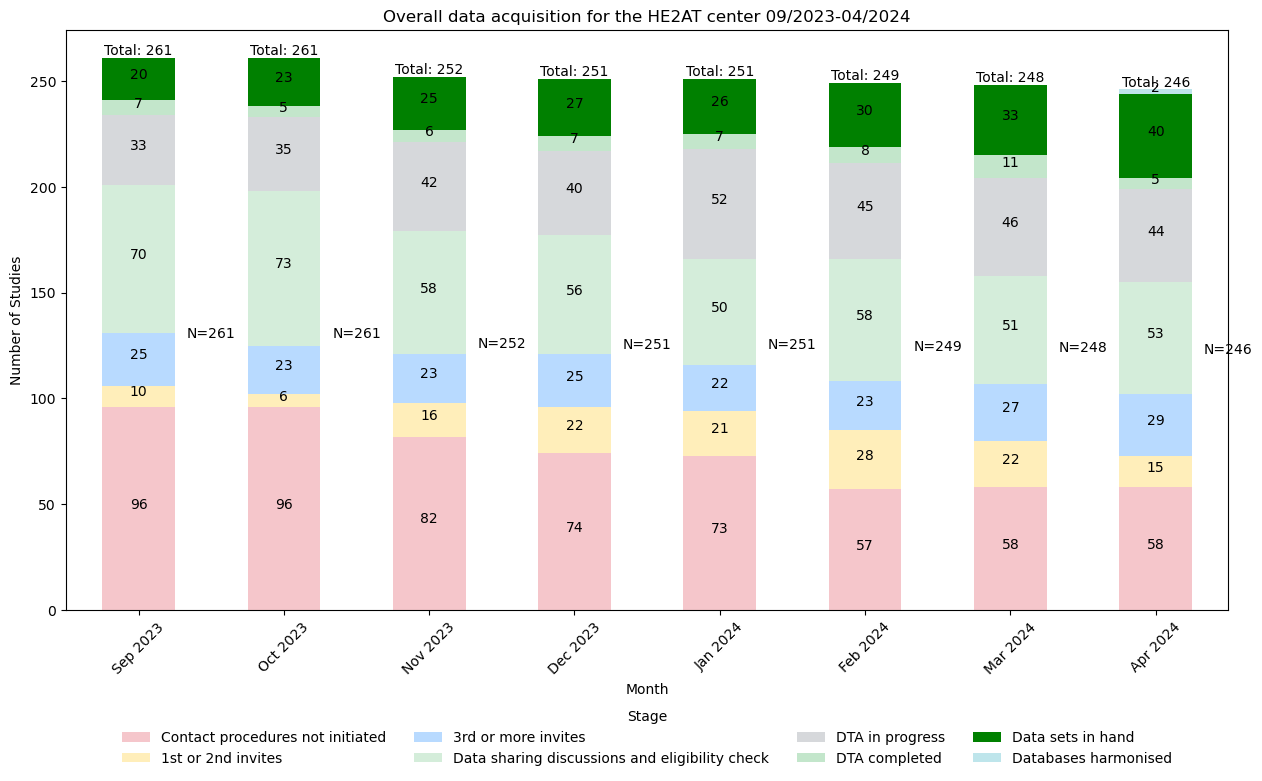

In [5]:
xlsx_file = pd.read_excel('HEAT_Tables_0422_am_1327.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1.index.tolist())
stages_abj = set(df_abj.index.tolist())
stages_jhb = set(df_jhb.index.tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#f5c6cb',
    '1st or 2nd invites': '#ffeeba',
    '3rd or more invites': '#b8daff',
    'Data sharing discussions and eligibility check': '#d4edda',
    'DTA in progress': '#d6d8db',
    'DTA completed': '#c3e6cb',
    'Data sets in hand': 'green',
    'Databases harmonised': '#bee5eb'
}
stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Databases harmonised'
]

# Plotting function for a single dataframe
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, label_shift=0.0):
    df = df.set_index('Stage').reindex(stage_order + ['Ineligible/declined participation/data currently unavailable']).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.drop('Stage', axis=1).transpose().sum()
        for i, month in enumerate(transposed_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, 0, f"n={int(excluded)} excluded", ha='center', va='bottom', color='red')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

plot_stacked_bar_chart(df_rp1, 'RP1 Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress 09/2023-04/2024', last_n_months=8, color_map=color_map, stage_order=stage_order, label_shift=0.4)

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order + ['Ineligible/declined participation/data currently unavailable']).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')
        ax.text(i, total_height, f'Total: {int(total_height)}', ha='center', va='bottom')

    if not excluded_df.empty:
        excluded_totals = excluded_df.transpose().sum()
        for i, month in enumerate(filtered_df.index):
            if month in excluded_totals.index:
                excluded = excluded_totals[month]
                if excluded > 0:
                    ax.text(i, 0, f"n={int(excluded)} excluded", ha='center', va='bottom', color='red')

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)




In [ ]:
import pandas as pd



# Create a DataFrame from the data
df_rp1_countries = pd.read_excel('data/HEAT_Tables_0422_am_2.xlsx', sheet_name='RP1_Countries')

# Calculate the total number of studies for each country
df_rp1_countries['Total Studies'] = df_rp1_countries.drop('Study site', axis=1).sum(axis=1)

# Create a formatted output for each country
df_rp1_countries['Formatted'] = df_rp1_countries['Study site'] + " (n=" + df_rp1_countries['Total Studies'].astype(str) + ")"
formatted_output = df_rp1_countries[['Study site', 'Formatted']].set_index('Study site')

# Print the formatted summary
print(formatted_output)


                            Formatted
Study site                           
Benin                   Benin (n=3.0)
Burkina Faso     Burkina Faso (n=4.0)
Cameroon             Cameroon (n=2.0)
Côte d'Ivoire   Côte d'Ivoire (n=1.0)
Ethiopia            Ethiopia (n=18.0)
Gambia                 Gambia (n=1.0)
Ghana                  Ghana (n=10.0)
Kenya                  Kenya (n=17.0)
Malawi                Malawi (n=19.0)
Nigeria               Nigeria (n=0.0)
Senegal               Senegal (n=1.0)
South Africa    South Africa (n=32.0)
Tanzania            Tanzania (n=23.0)
Multi-country  Multi-country (n=25.0)
